In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

matplotlib.rcParams['figure.facecolor'] = 'w'

In [2]:
from scgan.loader.colored_mnist_loader import ColoredMnistDataset
from scgan.model.scseparator_model import SCSeparatorResnetModel

In [3]:
DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [4]:
run_dir = os.path.join(RUN_ROOT, "mnist_sc_separate/")
os.makedirs(run_dir, exist_ok=True)

params = {'seed': 2222, 'num_epoch': 100, 'batch_size': 64, 'test_batch_size': 512,
          'learning_rate': 0.001, 'scheduler_gamma': 0.99, 'weight_decay': 0.0001,# 'clip_size': 3.,
          'lambda_idt': 1., 'lambda_cycle': 0.01, 'lambda_content': 0.01, 'lambda_style': 0.01, 'lambda_siamese': 1.,
          'gamma_content': 1., 'gamma_style': 1.,
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [5]:
train_dataset = ColoredMnistDataset(root=DATA_ROOT, train=True)
test_dataset = ColoredMnistDataset(root=DATA_ROOT, train=False)
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, params['test_batch_size'], shuffle=False, drop_last=False)
print(len(train_loader), len(test_loader))

937 20



Learning with learning rate:  0.00100000.

[1/100] 10'th step. [LOSS] 0.445104. [LOSS_IDT] 0.248119. [LOSS_CYCLE] 0.006461. [LOSS_CONTENT] 0.007192. [ACCURACY_CONTENT] 0.492188. [LOSS_STYLE] 0.007396. [ACCURACY_STYLE] 0.507812. [LOSS_SIAMESE] 0.175936. [NORM_S1] 0.417423. [NORM_S2] 0.516641
    Best Step:     10. Elapsed Time: 4.990656 seconds.
[1/100] 20'th step. [LOSS] 0.258507. [LOSS_IDT] 0.164238. [LOSS_CYCLE] 0.004494. [LOSS_CONTENT] 0.007204. [ACCURACY_CONTENT] 0.492188. [LOSS_STYLE] 0.007283. [ACCURACY_STYLE] 0.492188. [LOSS_SIAMESE] 0.075288. [NORM_S1] 0.272761. [NORM_S2] 0.433945
    Best Step:     20. Elapsed Time: 5.662858 seconds.
[1/100] 30'th step. [LOSS] 0.205928. [LOSS_IDT] 0.137285. [LOSS_CYCLE] 0.002888. [LOSS_CONTENT] 0.006972. [ACCURACY_CONTENT] 0.523438. [LOSS_STYLE] 0.006964. [ACCURACY_STYLE] 0.539062. [LOSS_SIAMESE] 0.051819. [NORM_S1] 0.226287. [NORM_S2] 0.372876
    Best Step:     30. Elapsed Time: 6.350021 seconds.
[1/100] 40'th step. [LOSS] 0.150009. [LOSS_I

OSError: [Errno 22] Invalid argument: 'D:\\NCIA\\Projects\\style-content-gan\\runs/mnist_sc_separate/result\\sampling_21400.png'

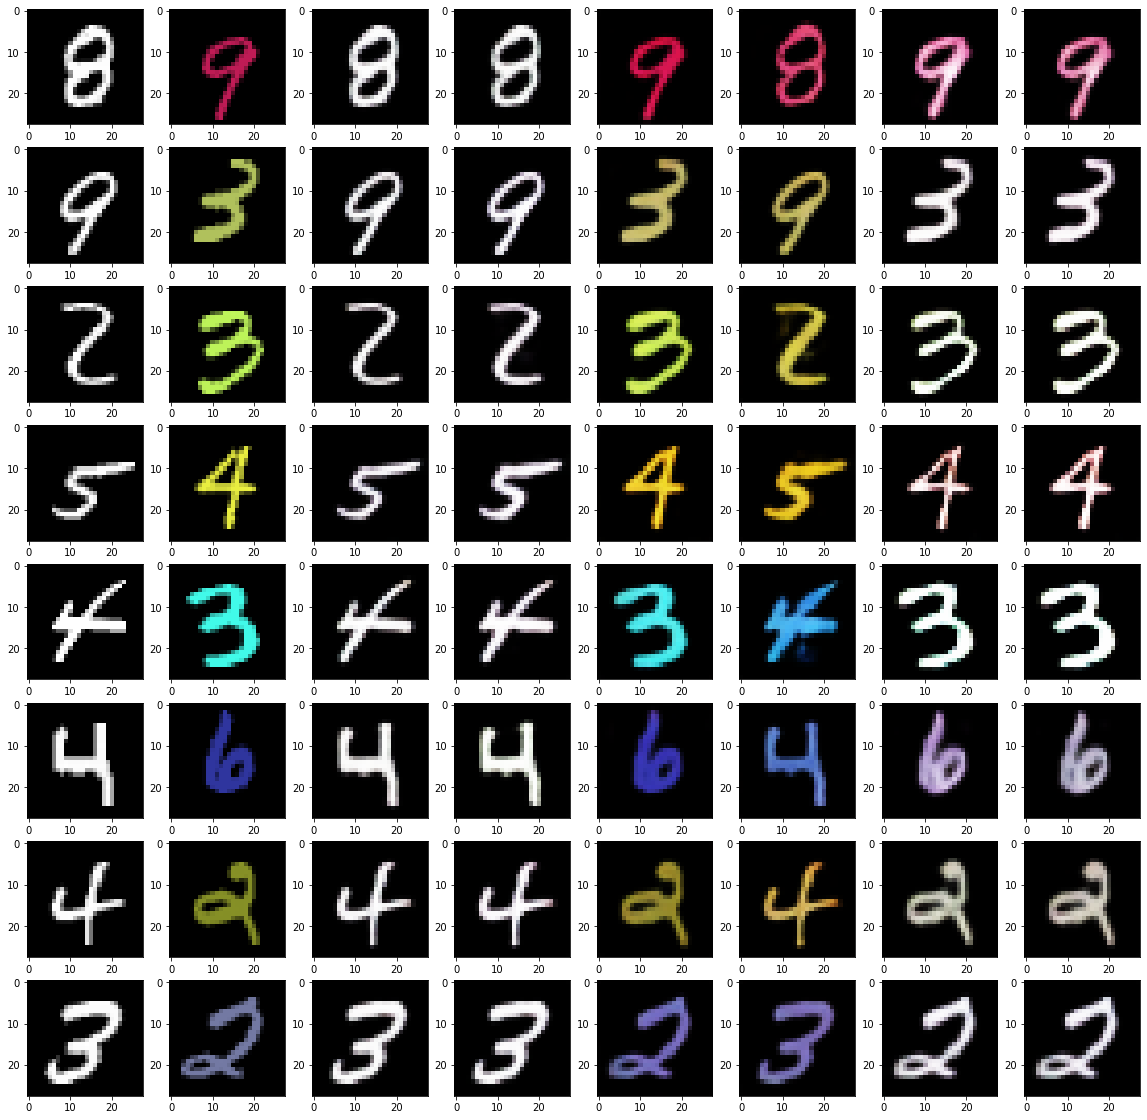

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sc_model = SCSeparatorResnetModel(device)
sc_model.train_model(train_loader, params=params)

In [11]:
all_input, all_output = sc_model.predict(test_loader)

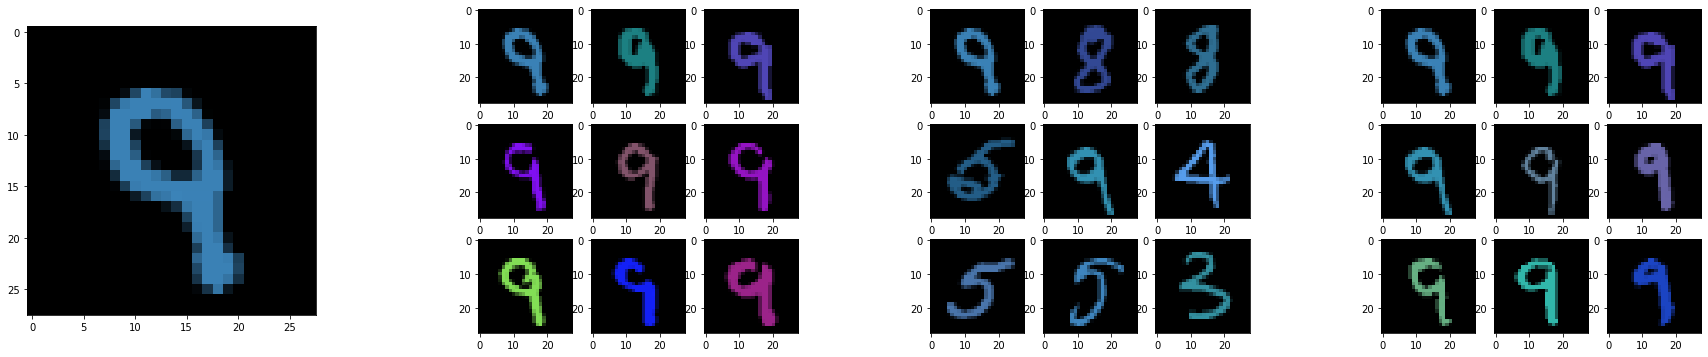

In [35]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()